In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from xgboost import XGBClassifier


In [2]:
# Load dataset - update path if needed
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Quick info
df.info()

# Drop customerID
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

# Convert TotalCharges (sometimes blank) to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Encode categorical features (LabelEncoder for simplicity)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != "Churn"]  # exclude target

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Map target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Final check
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [4]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (5634, 19) Test shape: (1409, 19)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
log_reg = LogisticRegression(max_iter=2000, solver="lbfgs")
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]


In [7]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)   # RF works fine on unscaled features, but we could also pass scaled ones
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


In [8]:
xgb = XGBClassifier(
    n_estimators=200,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]


=== Logistic Regression (scaled) ===
Accuracy : 0.7991
Precision: 0.6426
Recall   : 0.5481
F1 Score : 0.5916
AUC      : 0.8403
Confusion Matrix:
 [[921 114]
 [169 205]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8450    0.8899    0.8668      1035
           1     0.6426    0.5481    0.5916       374

    accuracy                         0.7991      1409
   macro avg     0.7438    0.7190    0.7292      1409
weighted avg     0.7913    0.7991    0.7938      1409

----------------------------------------


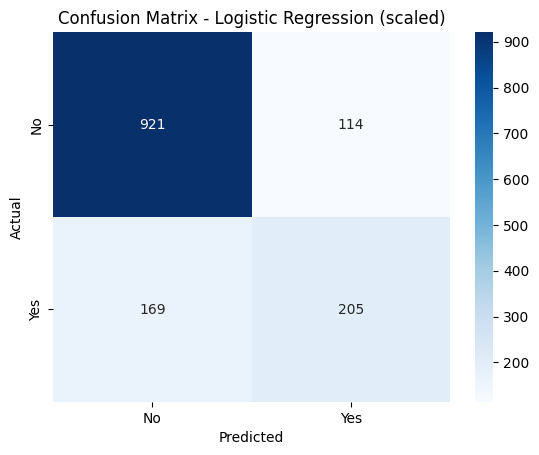

=== Random Forest ===
Accuracy : 0.7892
Precision: 0.6332
Recall   : 0.4893
F1 Score : 0.5520
AUC      : 0.8256
Confusion Matrix:
 [[929 106]
 [191 183]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8295    0.8976    0.8622      1035
           1     0.6332    0.4893    0.5520       374

    accuracy                         0.7892      1409
   macro avg     0.7313    0.6934    0.7071      1409
weighted avg     0.7774    0.7892    0.7799      1409

----------------------------------------


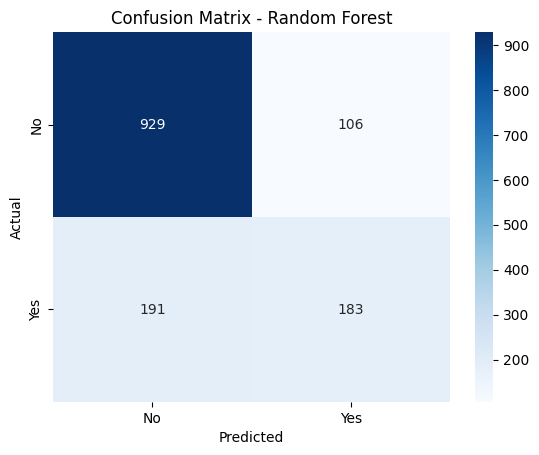

=== XGBoost ===
Accuracy : 0.7729
Precision: 0.5823
Recall   : 0.5107
F1 Score : 0.5442
AUC      : 0.8116
Confusion Matrix:
 [[898 137]
 [183 191]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8307    0.8676    0.8488      1035
           1     0.5823    0.5107    0.5442       374

    accuracy                         0.7729      1409
   macro avg     0.7065    0.6892    0.6965      1409
weighted avg     0.7648    0.7729    0.7679      1409

----------------------------------------


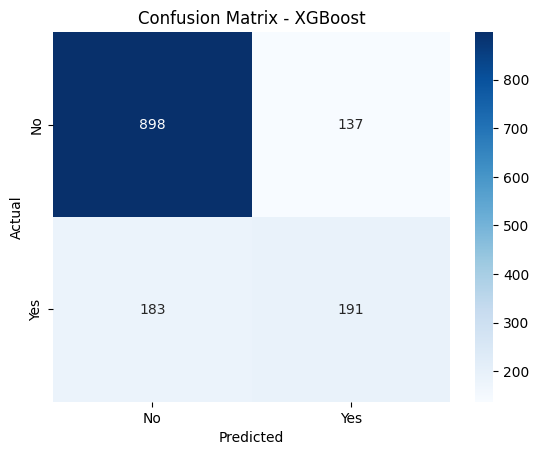

In [9]:
def evaluate_model(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y_true, y_pred)

    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("-"*40)

    # show confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No","Yes"], yticklabels=["No","Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc}

# Evaluate all three
results = []
results.append(evaluate_model("Logistic Regression (scaled)", y_test, y_pred_log, y_proba_log))
results.append(evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf))
results.append(evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb))


In [10]:
results_df = pd.DataFrame(results).set_index("model")
results_df = results_df[["accuracy","precision","recall","f1","auc"]]
results_df


,accuracy,precision,recall,f1,auc
model,,,,,
Logistic Regression (scaled),0.799148,0.642633,0.548128,0.591631,0.840280
Random Forest,0.789212,0.633218,0.489305,0.552036,0.825590
XGBoost,0.772889,0.582317,0.510695,0.544160,0.811563


In [12]:
best_by_recall = results_df["recall"].idxmax()
best_by_f1 = results_df["f1"].idxmax()

print("Best model by Recall   :", best_by_recall)
print("Best model by F1 score  :", best_by_f1)
print("\nRecommendation:")
if best_by_recall == best_by_f1:
    print(f"- Deploy **{best_by_recall}** (it has the best recall and F1).")
else:
    print(f"- Prefer **{best_by_recall}** if your main objective is to *catch as many churners as possible* (higher recall).")
    print(f"- Prefer **{best_by_f1}** if you want balance between precision and recall (higher F1).")

print("\nNote: Also consider business costs: false negatives (missed churners) often cost more than false positives (giving incentives to non-churners).")


Best model by Recall   : Logistic Regression (scaled)
Best model by F1 score  : Logistic Regression (scaled)

Recommendation:
- Deploy **Logistic Regression (scaled)** (it has the best recall and F1).

Note: Also consider business costs: false negatives (missed churners) often cost more than false positives (giving incentives to non-churners).


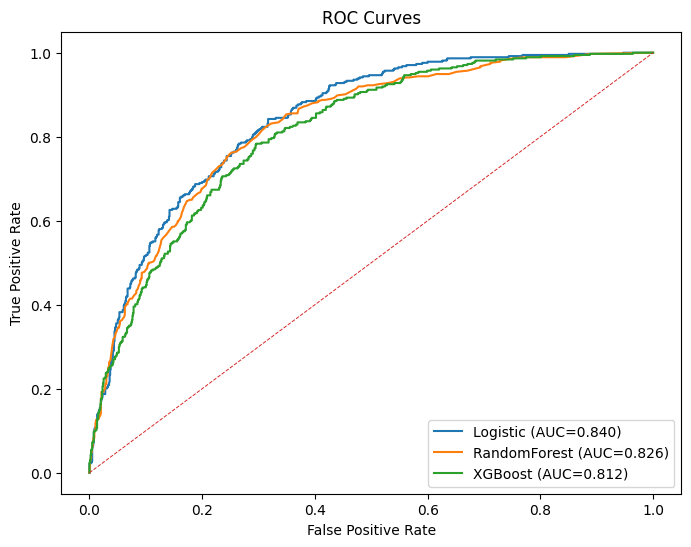

In [13]:
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, y_proba_log); plt.plot(fpr, tpr, label=f'Logistic (AUC={roc_auc_score(y_test,y_proba_log):.3f})')
fpr, tpr, _ = roc_curve(y_test, y_proba_rf); plt.plot(fpr, tpr, label=f'RandomForest (AUC={roc_auc_score(y_test,y_proba_rf):.3f})')
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb); plt.plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc_score(y_test,y_proba_xgb):.3f})')
plt.plot([0,1],[0,1],'--', linewidth=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()
